# LDA (Latent Dirichlet Allocation)

## Introduction

LDA is an unsupervised technique in the space of topic modeling. Broadly, given a bunch of texts, and the number of desired topics as an input, it categories each text into one or more topics 

Since it is not a supervised model, the topics don't make any natural sense beforehand. For example, if you want to separate a bunch of documents into sports, politics and science topics, what you can do is specify the no of topics as 3,
and LDA comes back and says that document 1 has 0.7 topic1, 0.2 topic 2, 0.1 topic 3;

document 2 has 0.5 topic 1, 0.5 topic 2 and 0 topic 3 for example

What topic1, 2, 3 correspond to from a domain standpoint - whether topic 1 is sports, or topic 1 is a mixture of sports and politics is something a human expert has to decide

## History

This is the original paper https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf, back in 2003. LDA still continues to be an influential algorithm in the space of topic modeling

## Theory - Summary

1) LDA is a generative probabilistic model. It assumes that Each topic is a mixture over an underlying set of words (ie : Topic 1 = 0.3 word1, 0.2, word2,..0.001 word 100);  and that each document is a mixture over topic probabilities
(ie Document 1 : 0.5 topic 1, 0.3 topic 2, 0.2 topic 3 for example)



2) Given M documents in the training corpus, N words (total number of words across all the documents including duplicates ), vocabulary V (no of unique words) and K topics (the number K is predefined),

the training process outputs

psi - The distribution of words for every topic
phi - The distribution of topics for every document

3) The way this is done is by using a kind of an iterative EM (Expectation maximization algorithm); where you assume a certain psi, estimate phi based on that, reestimate psi based on phi and so on.


4) More concretely, it assumes 2 dirichlet distributions, and 2 multinomial distributions (which are the conjugate priors of the dirichlet distributions)

a) The first dirichlet distribution (parametrized by alpha - Document topic dirichlet distribution) is used to sample a probability vector of size = the number of topics desired. For example, something like 0.7 topic1, 0.2 topic2, 0.1 topic3 if no of topics=3. Note that the sum of the probabilities is 1, as the domain of a dirichlet distribution is a probability simplex. This probability vector can be thought of as a sample document which is composed of these 3 topics in this fashion

Mathematically, $\theta_i \sim \ Dir(\alpha), i \epsilon [1..M]$
ie For Every document i from 1..M, each document is represented as a random mixture over latent topics

$\alpha $ is typically sparse i.e. $\alpha $ <  1



b)  Now, , take the second dirichlet distribution (parametrized by beta - topic word dirichlet distribution), where you want to get each topic as a vector of word probabilities


Mathematically, $\phi_k \sim \ Dir(\beta), k \epsilon [1..K]$
ie For Every topic k from 1 to K, represent each topic as a distribution over words 

$\beta $ is typically sparse i.e. $\beta $ <  1


Note that $\alpha , \beta$ are vectors of dimension K and N respectively


c) For each of the word positions i,j ($i \epsilon [1..M], j \epsilon [1..N_i]$ , ie Document i, Word j in document i, assuming there are a total of $N_i$ words in document i), do the following 

- Choose a topic $z_{i,j} \sim \ Multinomial(\theta_i)$. This gives you a candidate topic for every word 

- For every topic generated in step just above, use the dirichlet distribution in step b to sample words ie $w_{i,j} \sim \ Multinomial(\phi_{z_{i,j}})$




Ok, but how do you train for convergence with the parameters above ??

More specifically, how to you choose the dirichlet parameters $\alpha    and     \beta$ ?
You want to choose these parameters such that the the generated documents in step c above matches the real documents the best

How do you pose this as a loss function ?

## Theory - Details

Most of this from https://www.youtube.com/watch?v=4DsgCZ3KTNk and https://coli-saar.github.io/cl19/materials/darling-lda.pdf

This is what we said was the process earlier

1) for k in 1..K (across all topics)
        sample  $\phi^k \sim Dirichlet(\beta)$
        
2) For every document d in 1..D,
        a) sample $\theta_d \sim Dirichlet(\alpha)$                                                                               
        
        
        
        b) For each word $w_i$ in document d
                sample $z_i \sim Multinomial(\theta_d)$
               
               
                This gives a topic $z_i$for every word
                
                
         c)  sample new $w_i \sim Multinomial(\phi^{z_i})$
        
        
        


The only thing seen (non-hidden or non-latent) are the word vector w. The topic vector z, and the distributions theta and phi are latent variables. $\alpha$ and $\beta$ are the parameters

What we want to do is to estimate the topic vector z, theta, phi and the right values of alpha and beta, given the word vector w



What are thus interested is in the joint distribution 

P(w, z, theta, phi | alpha, beta) = P(phi|beta) * P(theta | alpha) * P(z | theta) * P(w | $phi^z$)


P(phi|beta) is the dirichlet distribution of topic over words (point 2a above), P(theta|alpha) is the dirichlet distribution of documents over topics (point 1 above), P(z | theta) is the multinomial distribution of generating topics from theta (Point 2b above), and P(w | $phi^z$) is the multinomial disibution of generating words from topic

## Inference

Not really inference as is more traditionally used in supervised ML
This is just reverse engineering the generative process

ie) Given that the joint distribution defined above generated the corpus with the seen variable word vector w, can we reverse engineer to find the posterior distributions of the latent variables z, phi, theta which generated the data set w

ie . Can we get P(z, phi, theta | alpha, beta, w) = P(z, phi, theta, w | alpha, beta) | P(w | alpha,beta )



This is intractable in a closed form, especially the term in the denominator P(w | alpha, beta), and we can't solve for this

So are we doomed ? No, this is where approximate techniques (based on EM ? ) such as Gibbs Sampling and Variational Inference helps

The original paper by Blei, Andrew and Jordan used variational inference (TODO : read up on this), but we are here using Gibbs sampling which is a MCMC (multi-chain-monte-carlo technique) for approximate inference



## So what is Gibbs Sampling ?

As mentioned earlier, a variation of multi-chain-monte-carlo

You write the posterior probability as conditional probabilities (chain !!) . You step through the chain repeatedly and reestimate the parameters until you converge on the posterior

For example, given a joint distribution p(x1, x2... xm) which you want to sample from, it is very difficult to sample directly from the joint distribution

Therefore, you first initialize all xi's randomly

Then for t=1..T


    1) $x_1^{t+1} \sim P(x_1$| x_2^{t}, x_3^{t},,x_m^{t})$  Each x_i is sampled from a conditional distribution keeping all other x_i constant
    
    
    
    2) $x_2^{t+1} \sim P(x_2| x_1^{t+1}, x_3^{t}... x_m^{t})$ Since we have reestimated x_1 alone, change the conditioning of x_1 alone to the new value at t+1
    
    
    
Repeat until convergence

Gibbs sampling is guaranteed theoretically to converge, but there is no way of saying how long it will take to converge. However, in practice , it is quite powerful

## Applying gibbs sampling to our problem

As mentioned in earlier sections, our goal is to estimate the latent variables theta, phi and z, given w and alpha, beta


ie we want to estimate P(theta, phi, z | w, alpha, beta)


This can be done in its full glory by taking each conditional distribution of theta , phi and z separately, but note that z is a sufficient statistic to compute theta and phi

ie given z, the topic assignment for every word, we can compute theta (the dirichlet distribution of document over topics - just the fraction of no of words assigned to every topic in that document)   and $phi_{k}$ (the dirichlet distribution of topic over words) - for every topic k, look at all the words which contributed to that topic across all documents, and take a fraction trivially


Given that, the problem statement simplifies to estimating P(z | w, alpha, beta) and theta, phi can be completely determined by z. This is called collapsed gibbs sampling

Now , just following the technique described above

we want to estimate $P(z_{i} | z_{-i}, w, alpha, beta)$  where $z_{i}$ is the topic of word i, and $z_{-i}$ is the collection of topics of all words except word i 


(in english, updating the topic a particular word, keeping all other topics constant)

In next iteration, the updated $z_{i}$ will be used to compute probability of the next word and this repeats

Rewrite $P(z_{i} | z_{-i}, w, alpha, beta)$ = $P(z_{i}, z_{-i}, w |  alpha, beta)$ / $P( z_{-i}, w |  alpha, beta)$


By the rules of conditional probability

The denominator $P( z_{-i}, w |  alpha, beta)$ is a constant for the current iteration as only the numerator contains $P(z_{i})$


Therefore, $P(z_{i} | z_{-i}, w, alpha, beta)$ is proportional to $P(z_{i}, z_{i}, w |  alpha, beta)$ which is nothing but 

 $P(z, w |  alpha, beta)$   as z = Union($z_{i}, z_{-i}$)
 
 
 

Now  $P(z, w |  alpha, beta) = \int\int P(z,w,\theta,\phi | alpha, beta) d\theta d\phi$

By the LDA definition above, 

$P(z,w,\theta,\phi | alpha, beta)  = P(\theta|alpha)*P(\phi|beta) * P(z|\theta) * P(w|\phi^{z})$

Plugging this in integration above, and grouping theta and phi terms,



$P(z, w |  alpha, beta) = \int P(\theta|alpha)*P(z|\theta) d\theta  * \int P(\phi|beta)*P(w|\phi_{z}) d\phi$



Since the dirichlet and the multinomial are conjugate priors, this simplifies significantly

as follows


$\int P(\theta|alpha)*P(z|\theta) d\theta = B(n_{d,.} + \alpha) | B(\alpha) $  

where B is the multinomial beta function, $n_{d,k}$ is the count of words in document d assigned to topic k, $n_{d,.}$ is summation over the k index 


Similarly, $\int P(\phi|beta)*P(w|\phi_{z}) d\phi = \prod_{k}   B(n_{k,.} + \beta) | B(\beta)  $


Therefore,  $P(z, w |  alpha, beta) = \prod_{d}   B(n_{d,.} + \alpha )| B(\alpha)   *  \prod_{k}   B(n_{k,.} + \beta )| B(\beta)  $




$B(\alpha) = \frac{\prod_{k}\Gamma(\alpha_{k})}{\Gamma(\sum_{k}(\alpha_{k}))} $

Now we had earlier written that 

 $P(z_{i} | z_{-i}, w, alpha, beta)$ = $P(z_{i}, z_{-i}, w |  alpha, beta)$ / $P( z_{-i}, w |  alpha, beta)$

 
  $P(z_{i} | z_{-i}, w, alpha, beta)$  = $P(z, w | alpha, beta)$ / $P( z_{-i}, w  | alpha , beta)$

Now $P(z, w | alpha, beta) = \prod_{d}   B(n_{d,.} + \alpha) | B(\alpha)   *  \prod_{k}   B(n_{k,.} + \beta )| B(\beta)  $


Similarly,

Now $P(z_{-i}, w | alpha, beta) = \prod_{d}   B(n_{d^{-i},.} + \alpha )| B(\alpha)   *  \prod_{k}   B(n_{k^{-i},.} + \beta) | B(\beta)  $


On substituing the full form of B in terms of the gamma function,

this simplifies to

 $P(z_{i} | z_{-i}, w, alpha, beta)$ is proportional to  $(n_{d,k^{-i}} + \alpha_{k}  ) * (n_{k,w^{-i}} + \beta_{w}  ) / (\sum_{w'}(n_{k,w'^{-i}} + \beta_{w'}  ))$ 

## Implementation

Phew ! Now what ? How do we actually implement this ?

The implementation is actually quite simple now that we have the final form !! - 

Looking at this form $(n_{d,k^{-i}} + \alpha_{k}  ) * (n_{k,w^{-i}} + \beta_{w}  ) / (\sum_{w'}(n_{k,w'^{-i}} + \beta_{w'}  ))$ ,

what we really need to apply gibbs sampling is

1) alpha (the complete vector, K components)
2) beta (the complete vector, N components)
3) $n_{d,k}$ - Count of words in document d, belonging to topic k
4) $n_{k,w}$ - Count of words where word=w, and topic=k

In addition, for ease, we store
5) $n_{k}$ - total count of words belonging to topic k  

6) z - topic vector containing current topic assignment for each of the N words in the corpus
 
That's it !! We need to make small corrections for the -i term in $n_{d,k}$ and $n_{k,w}$, but otherwise we are set

Here's the pseudocode

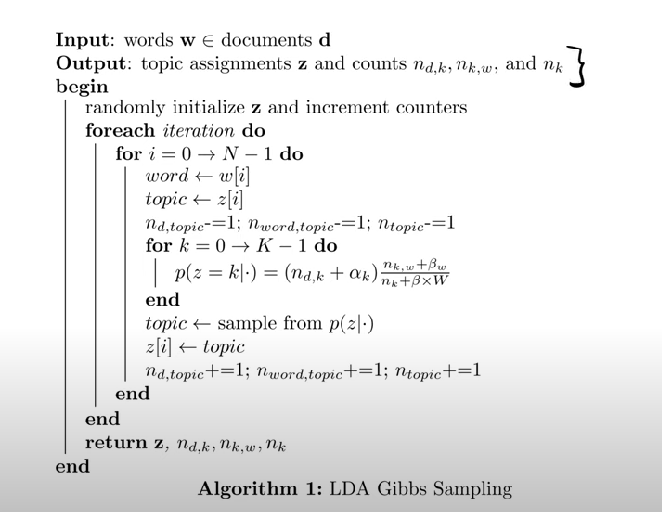

From this paper https://datascience.oneoffcoder.com/dirichlet-multinomial-distribution.html

## Coding from scratch

In [1]:
import numpy as np
import pandas as pd
print(pd.__version__)
from collections import Counter
from tqdm import tqdm
import spacy
import os
import random

2.0.1


### Load the dataset

This is the ENRON emails dataset, containing ~500K emails which we want to do topic modeling on

In [2]:
df = pd.read_csv("../../data/emails.csv")

In [21]:
df.shape

(517401, 14)

In [24]:
df.iloc[100]['content']

"I tried the new address but I don't have access.  also, what do I need to \nenter under domain?"

### Dirichlet parameters

In [3]:
ALPHA = 0.1
BETA = 0.1

## can optimize using hyperparameter search, initialize as symmetric
## ideally alpha should be a vector of length K, beta to vector of length No of words

NUM_TOPICS = 20 ## no of desired topics, has to be an input to the algorithm. can again be a hyperparamter to search on


sp = spacy.load("en_core_web_sm")

## reproducibility
np.random.seed(42)
random.seed(42)

### Helper Functions

In [4]:
def generate_frequencies(data, max_docs=10000):
    freqs = Counter()
    all_stopwords = sp.Defaults.stop_words ## spacy default stop words
    all_stopwords.add("enron") ## since this dataset is the enron dataset, enron can be a stopword as it is non descriptive
    nr_tokens = 0
    
    for doc in data[:max_docs]:
        tokens = sp.tokenizer(doc)
        for token in tokens:
            token_text = token.text.lower()
            if token_text not in all_stopwords and token.is_alpha:  ## is_alpha ensures it is alphabetical
                nr_tokens = nr_tokens + 1
                freqs[token_text] = freqs[token_text] + 1
                
    return freqs
            
        
    
    

def get_vocab(freqs, freq_threshold=3):
    vocab = {}
    vocab_idx_str = {}
    vocab_index = 0
    
    for word in freqs:
        if freqs[word]>=freq_threshold:
            vocab[word] = vocab_index
            vocab_idx_str[vocab_index] = word
            vocab_index = vocab_index + 1
    return vocab, vocab_idx_str
            
            
    

def tokenize_dataset(data, vocab, max_docs=10000):
    ## Clean up to remove words with less than desired freq, etc. Convert tokens to indices, return both
    nr_tokens = 0
    nr_docs = 0
    docs = []
    
    for doc in data[:max_docs]:
        tokens = sp.tokenizer(doc)
        if len(tokens)>1:
            tmp = []
            for token in tokens:
                token_text = token.text.lower()
                if token_text in vocab:
                    nr_tokens = nr_tokens + 1
                    tmp.append(token_text)
        nr_docs = nr_docs + 1
        docs.append(tmp)
        
    print(f"Number of emails : {nr_docs}")
    print(f"Number of tokens across documents : {nr_tokens}")
    
    
    ## Numericalize this
    
    corpus = []
    for doc in docs:
        corpus_d = []
        for token in doc:
            corpus_d.append(vocab[token])
            
        corpus.append(np.array(corpus_d))
        
    return docs, corpus
            
            
            
        
                    
                
            
        
    



In [5]:
data = df['content'].sample(frac=0.001, random_state=42 ).values
freqs = generate_frequencies(data, max_docs=10000 )
vocab, vocab_idx_str = get_vocab(freqs)
docs, corpus = tokenize_dataset(data, vocab)
vocab_size = len(vocab)




Number of emails : 517
Number of tokens across documents : 58199


In [35]:
vocab_size

24776

In [82]:
def lda_collapsed_gibbs(corpus, n_iter=200):
    
    ## Implement pseudo code above
    
    ## Initialize counts and Z randomly
    num_docs = len(corpus)
    Z = []
    for doc_idx, doc in enumerate(corpus):
        Zd = np.random.randint(low=0, high=NUM_TOPICS, size = len(doc) ) ## generate a vector of topic indices of size = no of words in document, initialize randomly
        Z.append(Zd)
    
    ndk = np.zeros((num_docs, NUM_TOPICS)) ## matrix of size num_docs * num_topics
    for d in range(num_docs):
        for k in range(NUM_TOPICS):
            ndk[d][k] = np.sum(Z[d]==k) ## Number of words in document d which belongs to topic k
            
    nkw = np.zeros((NUM_TOPICS, vocab_size)) ## matrix of size num_topics, vocab_size
    for doc_idx, doc in enumerate(corpus):
        for i, word in enumerate(doc):
            curr_topic = Z[doc_idx][i]
            nkw[curr_topic][word] = nkw[curr_topic][word]  + 1
            
    nk = np.sum(nkw, axis=1)
    
    topic_list = [i for i in range(NUM_TOPICS)]
    
    ## the actual for loop
    
    for _ in tqdm(range(n_iter)):
        for doc_idx, doc in enumerate(corpus):
            for i, word in enumerate(doc):
                word = doc[i]
                topic = Z[doc_idx][i]
                
                ## Do the condition on Z-i bit
                
                ndk[doc_idx][topic] = ndk[doc_idx][topic] - 1
                nkw[topic][word] = nkw[topic][word] - 1
                nk[topic] = nk[topic] - 1
                
                ## Compute pz
                
                pz = (ndk[doc_idx, :] + ALPHA) * (nkw[:, word] + BETA) / (nk[:] + BETA*vocab_size) ## vector implementation
                ## (ndk[doc_idx, :] + ALPHA) is of dimension (k,); (nkw[:, word] + BETA) is of dimension (k,)
                ## (ndk[doc_idx, :] + ALPHA) * (nkw[:, word] + BETA) is element wise multiplication of size (k,)
                ## (nk[:] + BETA*vocab_size) is of dimension k
                ## (ndk[doc_idx, :] + ALPHA) * (nkw[:, word] + BETA) / (nk[:] + BETA*vocab_size) is element wise division of numerator by denominator
                
                
                topic = random.choices(topic_list, weights=pz, k=1)[0] ## you want only 1 value sampled, hence k=1
                
                ## update parameters
                
                Z[doc_idx][i] = topic
                ndk[doc_idx][topic] = ndk[doc_idx][topic] + 1
                nkw[topic][word] = nkw[topic][word] + 1
                nk[topic] = nk[topic] + 1  
                
                
    return Z, ndk, nkw, nk
    
                
                
                
                
                
        
    
    
        
    
    
    
        
        
    
    
    

In [99]:
Z, ndk, nkw, nk = lda_collapsed_gibbs(corpus, n_iter=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


## Interpret output

In [90]:
nk.shape

(20,)

In [91]:
nk.reshape(NUM_TOPICS,1).shape

(20, 1)

In [100]:
phi = nkw/nk.reshape(NUM_TOPICS,1) ## The phi we talked about at the beginning , representing each topic as a word vector

In [ ]:
num_words = 10

for k in range(NUM_TOPICS):
    most_common_words = np.argsort(phi[k,:][::-1])[:num_words] ## indices of words with highest probability for topic k
    
    ## now using vocab idx to str, we get these words
    print(f"Topic {k} most common words")
    for word in most_common_words:
        print(vocab_idx_str[word])
        
    
    

## Coding using inbuilt python libraries

### Visualizing the data using wordcloud

In [112]:
from wordcloud import WordCloud
long_string = ','.join([",".join(x) for x in docs])

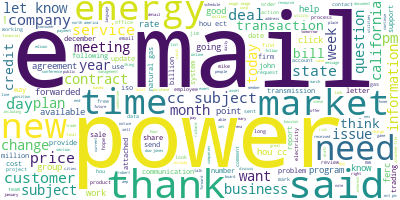

In [113]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Creating the same thing as above - vocab, corpus, idx2text using gensim inbuilt code

In [6]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(docs)

In [7]:
# Create Corpus
texts = docs
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 2), (9, 2), (10, 2), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 10), (22, 1), (23, 1), (24, 1), (25, 5), (26, 1), (27, 1), (28, 2), (29, 1)]


## Interpreting the tuple above in corpus
Basically just what we did above
corpus is a list of length = no of documents
each element of the list (corpus[0]) is a list of tuples, containing the word index, and count of words with index=that word in that document

So in document 1 (corpus[0]) , word with index=0 occurs 1 time ([(0,1)] as first element), etc



In [8]:
from pprint import pprint
import gensim
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"subject" + 0.008*"energy" + 0.007*"company" + 0.006*"said" + '
  '0.005*"time" + 0.005*"power" + 0.005*"pm" + 0.005*"gas" + 0.004*"hou" + '
  '0.004*"cc"'),
 (1,
  '0.014*"hou" + 0.011*"mail" + 0.010*"e" + 0.009*"subject" + 0.009*"pm" + '
  '0.008*"cc" + 0.006*"thanks" + 0.005*"energy" + 0.005*"corp" + 0.005*"gas"'),
 (2,
  '0.011*"hou" + 0.008*"power" + 0.008*"energy" + 0.007*"subject" + 0.006*"cc" '
  '+ 0.005*"pm" + 0.005*"company" + 0.004*"said" + 0.004*"deal" + '
  '0.004*"thanks"'),
 (3,
  '0.010*"power" + 0.007*"energy" + 0.007*"subject" + 0.004*"time" + '
  '0.004*"sent" + 0.004*"market" + 0.004*"company" + 0.004*"file" + '
  '0.004*"new" + 0.004*"said"'),
 (4,
  '0.016*"hou" + 0.008*"power" + 0.008*"image" + 0.007*"energy" + '
  '0.006*"subject" + 0.005*"thanks" + 0.005*"e" + 0.005*"pm" + 0.005*"cc" + '
  '0.004*"need"'),
 (5,
  '0.007*"hou" + 0.007*"e" + 0.006*"mail" + 0.006*"power" + 0.005*"energy" + '
  '0.005*"said" + 0.005*"subject" + 0.004*"market" + 0.004

### Analyzing LDA model results in gensim

Use the python visualization package pyLDAvis

This does 2 things

1) Better understanding and interpreting individual topics
       - Can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter.
       
2) Relations between topics
        -  Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [9]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [10]:
pyLDAvis.enable_notebook()

In [11]:
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

In [128]:
LDAvis_data_filepath 

'./results/ldavis_prepared_10'

In [12]:
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

In [13]:
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

This video describes how to interpret the plot above https://www.youtube.com/watch?v=IksL96ls4o0,
also see this paper https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf, and the documentation https://pypi.org/project/pyLDAvis/
a sample screenshot of which is below for clarity

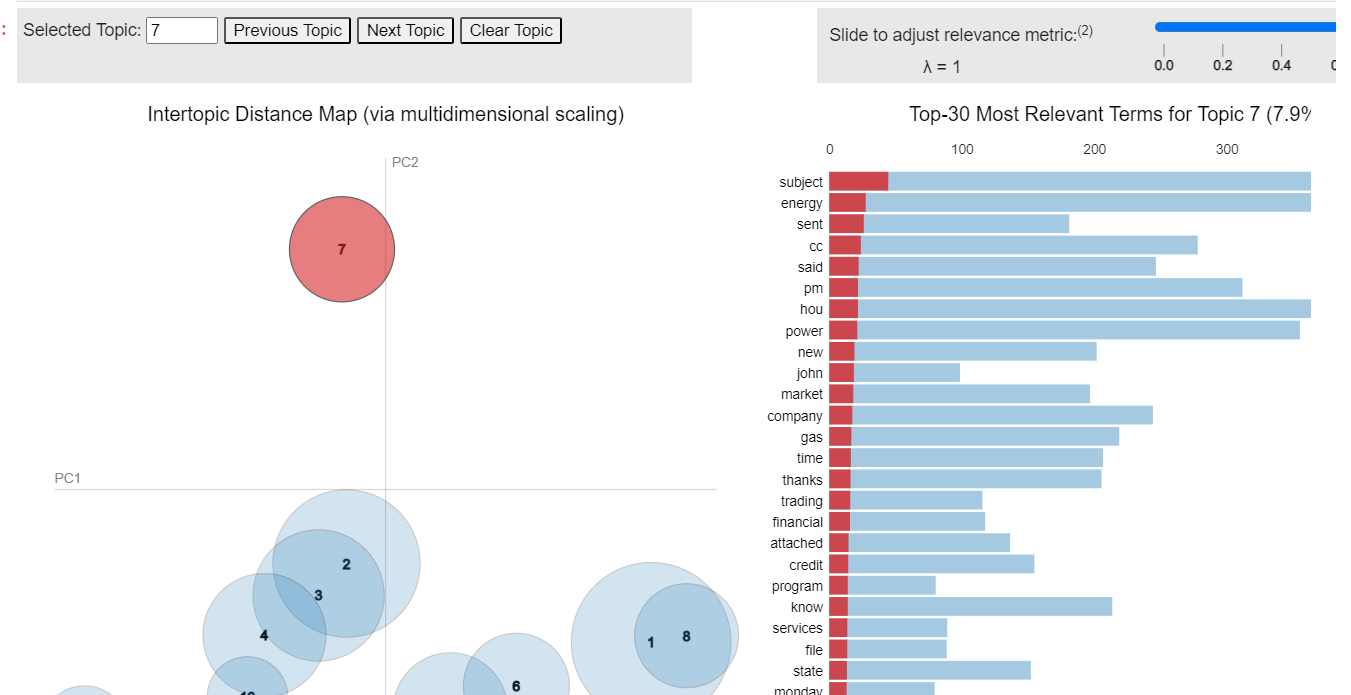

There are two panes here, left and right
In the left pane, you choose a topic at the top where 7 is (can be over the 20 topics)
On the left also, you see one sphere for each of the 20 topics, representing the principal components of the topic vectors in terms of words which phi gives (I think). Closer spheres are topics which are closer to each other by a distance metric. The area of the circle represents how many of the N total words this particular topic covers

On the right, you see a bar plot of words with 2 colors- red which represents the frequency counts of words for the specific selected topic 7 (nkw or phik); the blue represents the frequency counts of the same words across all the topics(nk)

For example, the word "subject" is the most commonly occuring word for topic 7, whose frequency is ~30 (from the plot above), but subject is also widely found in general (>300 across all documents)

The parameter lambda indicates roughly the importance of the proportion of frequency for that topic / frequency in general.
Reducing lambda pushes words to the top which have a higher ratio of frequency for that topic / frequency in general, decreasing lambda goes the other way round



Cons of LDA vis - 
1) hard for humans to judge relative areas of circles in the left / relative coverage of topics in the corpus
2) The principal coordinates / components don't mean anything interpretable, Depending on what projection technique to use to convert from N dimension to 2 dimension, the location of topics can vary in the projection space, and that can change your interpretation - For example , topics 2 and topic 5 can be close together by one projection algorithm, but far away in another



## Evaluating topic models

Largely based on https://www.youtube.com/watch?v=UkmIljRIG_M, https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Note that these evaluation approaches are not just for LDA, but any other kinds of topic models including LSA, pLSA, LDA, etc

Also note that the pyLDAvis above is one way of evaluating topic models

Evaluating topic models is hard, because there is no ground truth for topic assignment,
as a consequence, no technique is fool proof

Here are some ways to evaluate

1) Eye-balling models : Top N words per topic, topics identified for a specific document - qualitative, human in the loop - Eg visualization techniques - pyLDAvis, stanford Viz group papers (Chuang et al 2012, 2013)

2) Intrinsic evaluation approaches : Kind of what pyLDAvis and other tools and metrics do - model corpus structure, topic interpretability

3) Extrinsic evaluation - evaluation in the context of a downstream task

4) Human judgement - very nice, but can be subjective. Can lead to philosophical questions like "What is a topic" ?


What all do you need to capture in evaluation ?

i) Has the topic captured the internal semantic structure of the corpus ?
ii) Are the topics understandable ?
iii) Are the topics coherent ? (If you look at the top K words identified for a topic, do they feel like part of a group ?)
iv) Is the topic model good for the task ? There is no blanket "good", only task specific good




### Eye balling models

Already talked about pyLDAvis and its pros and cons, also check papers from stanford Viz group

### Intrinsic evaluation approaches

1) Perplexity

Similar to language models, perplexity is a commonly used metric (perplexity evaluated on the hold out set as usual, not the training data set) but its not good for this task, don't use perplexity !!

How is perplexity defined here ?


Check the article on Perplexity, but basically, If Q(w) is the predicted probability of the word (not the GT),
define perplexity as $2^{H(Q)}$, where H(Q) = $-\frac{\sum_{d=1}^{M}log(Q_{w{d}})}{\sum_{d=1}^{M}{n_{d}}}$, log is to the base 2

There is a problem here

How is Q(W) computed ?

If Q were over the training data set, you could say that Q(W=w|Document D) = $\sum_{k}P(Topic=k|D)*P(W=w|Topic=k)$

P(Topic=k|D) is essentially theta, computed from the $n_{dk}$ matrix, and P(W=w|Topic=k) is essentially $\phi^{k}$, computed from the $n_{kw}$ matrix

However, we want to compute perplexity over the hold out set, NOT the training data set

There's a problem ! P(W=w|Topic=k) learnt from training data set can be used for the hold out set as well, but P(Topic=k|D) learnt from the training data set cannot be used for the hold out set, as the Document population differs between training and hold out sets


https://stats.stackexchange.com/questions/18167/how-to-calculate-perplexity-of-a-holdout-with-latent-dirichlet-allocation

The way to do it properly is a bit involved, We need to integrate over theta (the dirichlet prior) over all possible topic mixtures



Some ways to do this using code are listed here
https://people.cs.umass.edu/~wallach/talks/evaluation.pdf

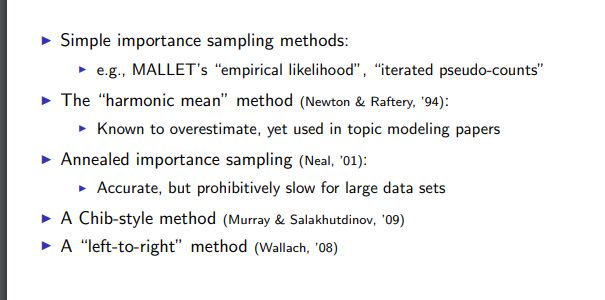






However, as mentioned above, even if you are able to compute perplexity for the validation data set, it doesn't align with human evaluation, so don't use perplexity or likelihood measures !!  https://proceedings.neurips.cc/paper/2009/file/f92586a25bb3145facd64ab20fd554ff-Paper.pdf


2) Some methods which talk about how to overcome the problem of perplexity is word intrusion and topic intrusion, as explained in the paper above

These are human in the loop methods
where the basic idea is

1) For word intrusion, pick a topic T from the theta distribution, and pick the top K-1 words associated with that topic from the phi distribution. Add 1 word w' to the K-1 words , which has a low probability of belonging to topic T, but a high probability of belonging to a different topic

If both a human and a model flag w' as the odd one out, it basically means the topic modeling is doing well, as this can be posed as a precision metric

Example : If the words for a topic are apple, banana, strawberry, computer - computer is the odd one out for a human, If a topic model also has computer from a different topic than apple, banana, strawberry, we are good !

This also measures coherence, ideally, if a topic model does well, the words picked by it are coherent. But if a topic model does poorly, the words will not be coherent, making it hard for human to pick a word intruder

For example, If the words picked from topic 1 are apple, spaceship, trump; and the word picked from the other topic is screw, it will be hard for a human too to pick the intruder from the words apple, spaceship, trump, screw ; as  apple, spaceship, trump are not coherent in the first place


2) For topic intrusion, the basic idea is very similar

This measures theta. Give the user a sample of text (could be just the header which was used for speed reasons by the authors above, or the whole document) - and present the top K-1 topics assigned to the text by the topic mixture model + 1 intruder topic which has nothing to do with that document (low probablity) - a topic is presented to the user using the top N words in the topic



# References

1) https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf
2) https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
3) https://www.youtube.com/watch?v=T05t-SqKArY
4) https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
5) https://www.youtube.com/watch?v=VTweNS8GiWI&t=1310s
6) https://www.youtube.com/watch?v=aPRjj8i_6yE - Important
7) https://www.youtube.com/watch?v=4DsgCZ3KTNk - Important
8) https://coli-saar.github.io/cl19/materials/darling-lda.pdf - Important
9) https://datascience.oneoffcoder.com/dirichlet-multinomial-distribution.html - on dirichlet distributions
10) https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0 - Evaluating topic models
11) https://www.youtube.com/watch?v=UkmIljRIG_M - again evaluating topic models
12) https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0 - Implementing in python using gensim